# Medical Entity Recognition

We will be looking at using multiple entities in our dataset, attempting to improve on the Bidirectional LSTM and further exploration

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

Using TensorFlow backend.


## Load and Parse Data

Dataset is slightly more difficult to parse when loaded using pandas hence will use pandas results for convenience when building custom parser. Also use pandas df to build relevant dictionaries for convenience.

In [3]:
train_dev_data = pd.read_csv("NERdata/NCBI-disease/train_dev.tsv", sep = "\t", header = None)

In [4]:
train_dev_data.head(20)

,0,1
0,Identification,O
1,of,O
2,APC2,O
3,",",O
4,a,O
5,homologue,O
6,of,O
7,the,O
8,adenomatous,B
9,polyposis,I


In [5]:
def load_data(file_path):
    file = open(file_path, "r")
    data, entities, sentence, unique_labels = [], [], [], []
    for line in file:
        line = line.strip("\n").split("\t")
        
        if len(line) > 1:
            word = line[0]
            label = line[1]
            
            sentence.append(word)
            entities.append(label)
            
            if label not in unique_labels:
                unique_labels.append(label)
            
        elif len(entities) > 0:
            sentence = " ".join(sentence)
            data.append({"sentence" : sentence, "entities" : entities})
            entities, sentence = [], []
            
    file.close()
    return data, unique_labels

In [6]:
filepath = "NERdata/NCBI-disease/train_dev.tsv"

data, unq_labels = load_data(filepath)

In [7]:
data[0]

{'sentence': 'Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .',
 'entities': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'I',
  'O',
  'O']}

In [8]:
#Check how many datapoints and unique labels we have acquired from the dataset

len(data), len(unq_labels)

(6347, 3)

## Feature Engineering

In [10]:
#Now we will make reference dictionaries for the text elements

from collections import Counter

def get_mappings(data, word_ent):

    if word_ent == "word" or word_ent == "char":
        vocab = list(set([i for x in data for i in x['sentence'].split()]))
    elif word_ent == "ent":
        vocab = list(set([i for x in data for i in x['entities']]))
    
    
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    
    return tok2idx, idx2tok


word2idx, idx2word = get_mappings(data, "word")
tag2idx, idx2tag = get_mappings(data, "ent")

n_words = len(word2idx)

In [11]:
# We will add a PAD token to consider padding during training

word2idx["PAD"] = n_words
idx2word[n_words] = "PAD"

In [12]:
n_words = len(word2idx)

print("There are {} unique words/elements in the corpus being considered".format(n_words))

There are 10057 unique words/elements in the corpus being considered


For convenience let us create a Pandas df summarising all the reelvant data to this point

In [13]:
columns = ["Sentence", "Labels", "Word Tokens", "Label Tokens"]

data_df = []
for i in range(len(data)):
    #We want data in the form : [Sentence, Labels, Words Tokens, Label Tokens]
    sentence = data[i]['sentence']
    labels = data[i]['entities']
    words = sentence.split()
    word_tkns = [word2idx.get(i) for i in words]
    label_tkns = [tag2idx.get(i) for i in labels]
    
    data_df.append([sentence, labels, word_tkns, label_tkns])
    
data_df = pd.DataFrame(data_df, columns = columns)

In [14]:
data_df.head()

,Sentence,Labels,Word Tokens,Label Tokens
0,"Identification of APC2 , a homologue of the ad...","[O, O, O, O, O, O, O, O, B, I, I, I, O, O]","[9730, 2499, 1791, 3632, 6545, 611, 2499, 4792...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1]"
1,The adenomatous polyposis coli ( APC ) tumour ...,"[O, B, I, I, I, I, I, I, O, O, O, O, O, O, O, ...","[826, 5985, 9442, 3827, 6826, 1097, 4897, 3507...","[1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ..."
2,Complex formation induces the rapid degradatio...,"[O, O, O, O, O, O, O, O, O]","[1491, 1433, 3475, 4792, 9189, 9775, 2499, 521...","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,"In colon carcinoma cells , loss of APC leads t...","[O, B, I, O, O, O, O, O, O, O, O, O, O, O, O, ...","[5781, 3290, 6832, 5496, 3632, 3047, 2499, 109...","[1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Here , we report the identification and genomi...","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[15, 3632, 2866, 9104, 4792, 6679, 4581, 2285,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


<BarContainer object of 3 artists>

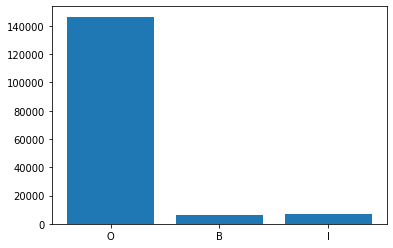

In [15]:
from collections import Counter

labels = [i for x in data_df["Labels"].values for i in x]
cnt = Counter(labels)
plt.bar(cnt.keys(), cnt.values())

In [16]:
cnt

Counter({'O': 146544, 'B': 5921, 'I': 7205})

Dataset is heavily unbalanced as expected hence we must use relevant metrics to appropriately train and evaluate models going forward. Let us remove sentences where we only come across a single label i.e. only "O"

In [17]:
del train_dev_data, data

Let us look at the sentence lengths and find an appropriate padding length

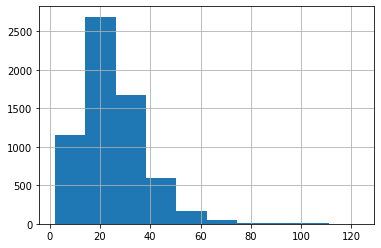

count    6347.000000
mean       25.156767
std        12.523920
min         2.000000
25%        16.000000
50%        23.000000
75%        32.000000
max       123.000000
Name: Word Tokens, dtype: float64

In [18]:
lengths = data_df['Word Tokens'].map(len)

lengths.hist()
plt.show()

lengths.describe()

In [19]:
VEC_DIM = 123

padded_sentences = pad_sequences(data_df["Word Tokens"], maxlen=VEC_DIM, dtype='int32', padding='post', truncating='post', value= word2idx["PAD"])
padded_labels = pad_sequences(data_df["Label Tokens"], maxlen = VEC_DIM, dtype='int32', padding='post', truncating='post', value= tag2idx["O"])
padded_labels = np.array([to_categorical(i, num_classes = len(tag2idx)) for i in padded_labels])

no_samples = np.shape(padded_sentences)[0]

In [20]:
pad_sequences(data_df["Label Tokens"], maxlen = VEC_DIM, dtype='int32', padding='post', truncating='post', value= tag2idx["O"])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [0, 2, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [37]:
idx = list(range(no_samples))

train_idx, val_test_idx = train_test_split(idx, test_size = 0.6, shuffle = True, random_state = 2021)
val_idx, test_idx = train_test_split(val_test_idx, test_size = 0.5)

train_sent, train_labels = padded_sentences[train_idx], padded_labels[train_idx]
val_sent, val_labels = padded_sentences[val_idx], padded_labels[val_idx]
test_sent, test_labels = padded_sentences[test_idx], padded_labels[test_idx]

## Build Model

In [70]:
def get_model(vocab_size, input_shape, lr = 0.001):
    EMB_DIM = 64

    inputs = Input(shape = (input_shape,))

    emb = Embedding(input_dim=vocab_size + 1, output_dim=EMB_DIM, trainable = True, name = "embed")
    lstm = Bidirectional(LSTM(units=EMB_DIM, return_sequences=True, dropout=0.2), merge_mode = 'concat', name = "bilstm")
    tdd = TimeDistributed(Dense(3, activation="softmax"), name = "tdd")
    
    x = emb(inputs)
    x = lstm(x)
    output = tdd(x)

    model = Model(inputs, output)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
    model.summary()
    
    return model

In [71]:
model = get_model(n_words, VEC_DIM)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 123)]             0         
_________________________________________________________________
embed (Embedding)            (None, 123, 64)           643712    
_________________________________________________________________
bilstm (Bidirectional)       (None, 123, 128)          66048     
_________________________________________________________________
tdd (TimeDistributed)        (None, 123, 3)            387       
Total params: 710,147
Trainable params: 710,147
Non-trainable params: 0
_________________________________________________________________


In [72]:
file_path = "mer.h5"
BATCH_SIZE = 128

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_ = ReduceLROnPlateau(monitor="val_loss", mode='min', patience=5, min_lr=1e-6)

history = model.fit(train_sent, train_labels, batch_size = BATCH_SIZE, validation_data= (val_sent, val_labels), epochs = 10)#, callbacks=[es, checkpoint, reduce_], verbose = 1)
model.save_weights(file_path)

Train on 2538 samples, validate on 1904 samples
Epoch 1/10
2538/2538 [==============================] - 8s 3ms/sample - loss: 0.5337 - accuracy: 0.9711 - val_loss: 0.1028 - val_accuracy: 0.9832
Epoch 2/10
2538/2538 [==============================] - 5s 2ms/sample - loss: 0.1000 - accuracy: 0.9830 - val_loss: 0.0811 - val_accuracy: 0.9832
Epoch 3/10
2538/2538 [==============================] - 5s 2ms/sample - loss: 0.0739 - accuracy: 0.9830 - val_loss: 0.0715 - val_accuracy: 0.9832
Epoch 4/10
2538/2538 [==============================] - 5s 2ms/sample - loss: 0.0675 - accuracy: 0.9830 - val_loss: 0.0669 - val_accuracy: 0.9832
Epoch 5/10
2538/2538 [==============================] - 5s 2ms/sample - loss: 0.0630 - accuracy: 0.9830 - val_loss: 0.0639 - val_accuracy: 0.9832
Epoch 6/10
2538/2538 [==============================] - 5s 2ms/sample - loss: 0.0593 - accuracy: 0.9830 - val_loss: 0.0614 - val_accuracy: 0.9832
Epoch 7/10
2538/2538 [==============================] - 5s 2ms/sample - loss

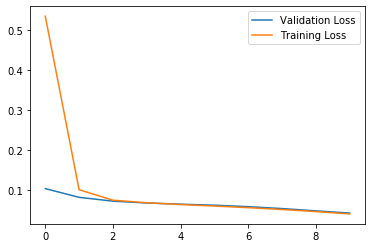

In [73]:
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.plot(history.history['loss'], label = "Training Loss")
plt.legend(loc = "best")

In [49]:
loss, acc = model.evaluate(test_sent, test_labels)

1905/1905 [==============================] - 1s 535us/sample - loss: 0.0286 - accuracy: 0.9924


In [50]:
acc

0.9923607

In [51]:
preds = model.predict(test_sent)

In [52]:
np.shape(test_labels), np.shape(preds)

((1905, 123, 3), (1905, 123, 3))

In [53]:
pred_labels = [idx2tag[np.argmax(x)] for i in preds for x in i]
Counter(pred_labels)

Counter({'O': 231268, 'B': 1467, 'I': 1580})

In [54]:
test_single_labels = [idx2tag[np.argmax(i)] for x in test_labels for i in x]

In [55]:
from sklearn.metrics import classification_report

print(classification_report(pred_labels, test_single_labels, labels = ["I", "B"]))

              precision    recall  f1-score   support

           I       0.60      0.82      0.69      1580
           B       0.65      0.76      0.70      1467

   micro avg       0.62      0.79      0.70      3047
   macro avg       0.62      0.79      0.70      3047
weighted avg       0.62      0.79      0.70      3047



In [66]:
[idx2tag[np.argmax(i)] for i in preds[2]]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B',
 'I',
 'I',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [65]:
test_labels[2]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0

In [69]:
" ".join([idx2word[i] for i in test_sent[2]])

'Genetic linkage map of six polymorphic DNA markers around the gene for familial adenomatous polyposis on chromosome 5 . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'